In [11]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
data_PATH = 'AAPL.csv'
# Target stock length
k = 200
len_base = int(k/40)

In [13]:
# Simplify the stock
def find_interval(price,len_base):
    # price: a series of stock data
    # len_base: a parameter that Determine the degree of simplification
    length = len(price)
    MIN = []
    MAX = []
    position = []
    i = 0
    his = 0
    p_len = []
    while(i <= length):
        inter = len_base

        if i+inter >= length:
            if i >= length:
                break
            MIN.append(min(price[i:]))
            MAX.append(max(price[i:]))
            break

        interval = price[i:]
        low_inter =  find_min(interval, inter)
        high_inter = find_max(interval, inter)
        
        MIN.append(min(low_inter))
        MAX.append(max(high_inter))

        #position always take the larger interval
        # drop interval
        if(len(low_inter) > len(high_inter)):
            p_len.append(i+list(low_inter).index(min(low_inter)))
            i += len(low_inter)
            position.append(min(low_inter))
            his = -1
        # up interval
        elif(len(low_inter) < len(high_inter)):
            p_len.append(i+list(high_inter).index(max(high_inter)))
            i += len(high_inter)
            position.append(max(high_inter))
            his = 1
        # special case, same length (different from previous one)
        else:
            if his == 1:
                p_len.append(i+list(low_inter).index(min(low_inter)))
                i += len(low_inter)
                position.append(min(low_inter))
                his = -1
            else:
                p_len.append(i+list(high_inter).index(max(high_inter)))
                i += len(high_inter)
                position.append(max(high_inter))
                his = 1
    return MIN,MAX,position,p_len
    
def find_min(interval, scale_len):
    i = 1
    while(True):
        if (i+1)*scale_len >= len(interval):
            return interval
        elif min(interval[:i*scale_len]) > min(interval[:(i+1)*scale_len]):
            i += 1
        else:
            return interval[:i*scale_len]

def find_max(interval, scale_len):
    i = 1
    while(True):
        if (i+1)*scale_len >= len(interval):
            return interval
        elif max(interval[:i*scale_len]) < max(interval[:(i+1)*scale_len]):
            i += 1
        else:
            return interval[:i*scale_len]
def normal(data):
    data = np.array(data)
    return (data - np.min(data))/(np.max(data) - np.min(data))

# Find related stock algorithm, return a number the smaller the better
def dtw(a, b):
    dis = np.full((len(a) + 1, len(b) + 1), np.inf)
    dis[0, 0] = 0
    for i in range(0, len(a)):
        for j in range(0, len(b)):
            dis[i + 1, j + 1] = (a[i] - b[j]) ** 2
    for i in range(1, len(a) + 1):
        for j in range(1, len(b) + 1):
            dis[i, j] = min(dis[i - 1, j - 1], dis[i, j - 1], dis[i - 1, j]) + dis[i, j]
    result = dis[len(a)-1, len(b)-1] / (len(a) + len(b))
    return result
# x = [2, 0, 1, 1, 2, 4, 2, 1, 2, 0]
# y = [1, 1, 2, 4, 2, 1, 2, 0]
# print(dtw(x, y))

# return the smallest dtw result in one stock data
def dtw_match(t1, t2):
    L1 = t1[0]
    L2 = t2[0]
    p1 = t1[1]
    p2 = t2[1]
    matched_interval = []
    record = 100
    true_len2 = L2[-1] - L2[1]
    # print(true_len2)
    for i in range(len(p1)-len(p2)):
        true_len1 = L1[i+len(p2)]-L1[i]
        if true_len1 < true_len2*1.5 and true_len1 > true_len2*0.75:
            t = dtw(normal(p1[i:i+len(p2)]), normal(p2))
            if t < record:
                record = t
                print(true_len1)
                # change p1[i:i+len(p2)]  ->  p1[i:i+2*len(p2)]  to see the trend
                matched_interval = p1[i:i+len(p2)]
    return  record, matched_interval
# dtw_match([LEN,AVG], [target[3],target[2]])
def search_sequence_numpy(arr,seq):
    # Store sizes of input array and sequence
    Na, Nseq = arr.size, seq.size
    # Range of sequence
    r_seq = np.arange(Nseq)
    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na-Nseq+1)[:,None] + r_seq] == seq).all(1)
    # Get the range of those indices as final output
    if M.any() >0:
        t = np.where(np.convolve(M,np.ones((Nseq),dtype=int))>0)[0]
        return int(t[0]), int(t[-1])
    else:
        return [], []         # No match found


# lab work

#shape detection
def is_top(AVG):
    mid = AVG[1:-1]
    if np.mean(AVG[0]+AVG[-1]) < np.mean(mid) and AVG[-1] < np.mean(mid):
        return True
    else:
        return False
def is_bottom(AVG):
    mid = AVG[1:-1]
    if np.mean(AVG[0]+AVG[-1]) > np.mean(mid) and AVG[-1] > np.mean(mid):
        return True
    else:
        return False
def is_up(AVG):
    mid = AVG[1:-1]
    if AVG[0]<np.mean(mid) and AVG[-1]>np.mean(mid):
        return True
    else:
        return False
def is_drop(AVG):
    mid = AVG[1:-1]
    if AVG[0]>np.mean(mid) and AVG[-1]<np.mean(mid):
        return True
    else:
        return False
def top_shape(AVG):
    sort_max = sorted(AVG[1:-1], reverse = True)
    index = []
    for i in sort_max:
        index.append(AVG.index(i))
    # print(index)
    if index[0]>index[1] and index[1]<index[2]  and abs(index[0]-index[1]) > 1 and abs(index[0]-index[2]) > 1:
        return 'head top'
    elif 2*abs(sort_max[0]-sort_max[1]) < abs(sort_max[1]-sort_max[2])  and abs(index[0]-index[1]) > 1:
        return 'two top'
    elif 2*abs(sort_max[0]-sort_max[1]) >= abs(sort_max[1]-sort_max[2]) and abs(index[0]-index[1]) > 1 and abs(index[0]-index[2]) > 1:
        return 'three top'
    else:
        return 
def bottom_shape(AVG):
    sort_min = sorted(AVG[1:-1])
    index = []
    for i in sort_min:
        index.append(AVG.index(i))
    if index[0]>index[1] and index[1]<index[2]:
        return 'head bottom'
    elif 2*abs(sort_min[0]-sort_min[1]) < abs(sort_min[1]-sort_min[2]) and abs(index[0]-index[1]) > 1:
        return 'two bottom'
    elif 2*abs(sort_min[0]-sort_min[1]) >= abs(sort_min[1]-sort_min[2]) and abs(index[0]-index[1]) > 1 and abs(index[0]-index[2]) > 1:
        return 'three bottom'
    else:
        return 

# def is_triangle(AVG):
    

In [14]:
def get_data(price,len_base):
    min_max = find_interval(price,len_base)
    MIN = [price[0]]+min_max[0]+[price[len(price)-1]]
    MAX = [price[0]]+min_max[1]+[price[len(price)-1]]
    AVG = [price[0]]+min_max[2]+[price[len(price)-1]]
    LEN = [0]+min_max[3]+[len(price)-1]
    return MIN,MAX,AVG,LEN
def get_shape(price):
    shape_list = []
    top = top_shape(price)
    # check up or down
    if is_up(price):
        return ['up']
    elif is_drop(price):
        return ['down']
    # check top and bottom if no trend
    else:
        if top != None:
            shape_list.append(top_shape(price))
        bottom = bottom_shape(price)
        if bottom != None:
            shape_list.append(bottom)
        if shape_list == []:
            return 'unknown'
        else:
            return shape_list
    

In [15]:
p = [1,4,2,3]
a = sorted(p, reverse =True)
b = []
for i in a:
    b.append(p.index(i))
print(a)
b

[4, 3, 2, 1]


[1, 3, 2, 0]

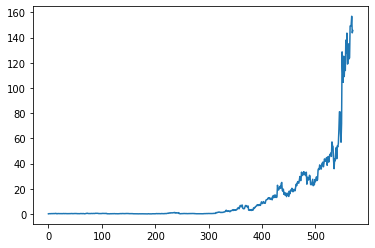

In [16]:
df = pd.read_csv(data_PATH)
open = np.array(df['Open'][:])
# return simplify stock data
# mainly use data[2]
data = get_data(open,len_base)

plt.plot(data[2])

['up']

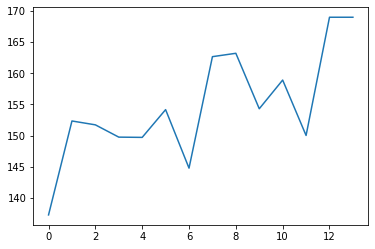

In [17]:
# target stock
df1 = pd.read_csv('IBM.csv')
target_open = np.array(df1['Open'][-7*k:-6*k])
target = get_data(target_open,len_base)
plt.plot(target[2])
get_shape(target[2])

192
185
186


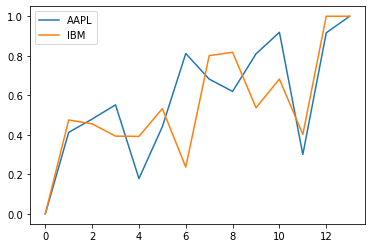

0.006057152364334761


In [18]:
value_dtw, matched_interval = dtw_match([data[3],data[2]], [target[3],target[2]])
ts_a = normal(matched_interval)
ts_b = normal(target[2])
plt.plot(ts_a, label='AAPL')
plt.plot(ts_b, label='IBM')
plt.legend()
plt.show()
print(value_dtw)

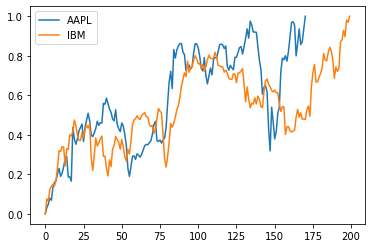

In [19]:
i0, i1 = search_sequence_numpy(np.array(data[2]),np.array(matched_interval))
matched_data = np.array(df['Open'][data[3][i0]:data[3][i1]])
plt.plot(normal(matched_data), label='AAPL')
plt.plot(normal(target_open), label = 'IBM')
plt.legend()
plt.show()